In [1]:
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 769 (items) x 256 (major_axis) x 201 (minor_axis)
Items axis: 0 to 768
Major_axis axis: 0 to 255
Minor_axis axis: 0 to 200

In [3]:
FREQ = 250 # Hz
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def plot_electrode(x):
    plt.plot(np.linspace(-200,600,201), x, alpha=0.5)

def plot_welch(x):
    f, power = signal.welch(x, fs=FREQ, nperseg=len(x), nfft=2048)
    plt.plot(f, power, '-')
    #plt.yscale('log')
    plt.xlim(-2,45)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [V^2/Hz]')

# Un solo Epoch

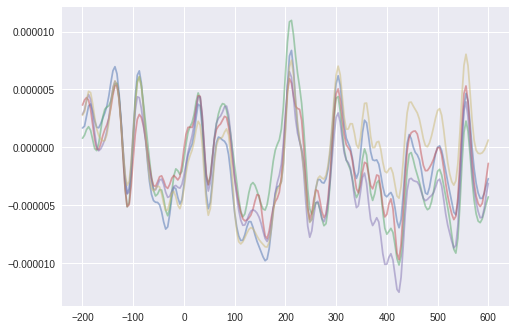

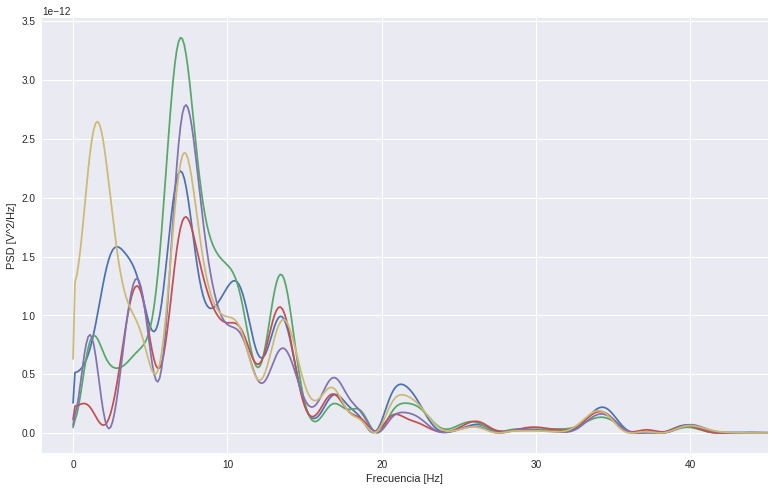

In [4]:
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(panel[0,electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(panel[0,electrode])
plt.show()

# Promedio entre Epochs

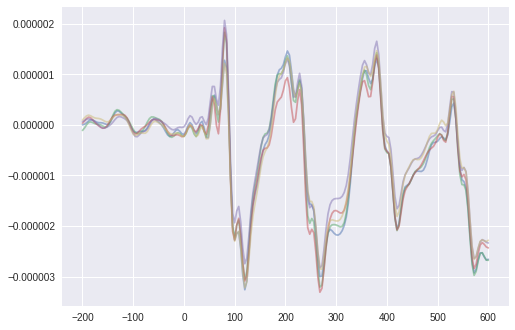

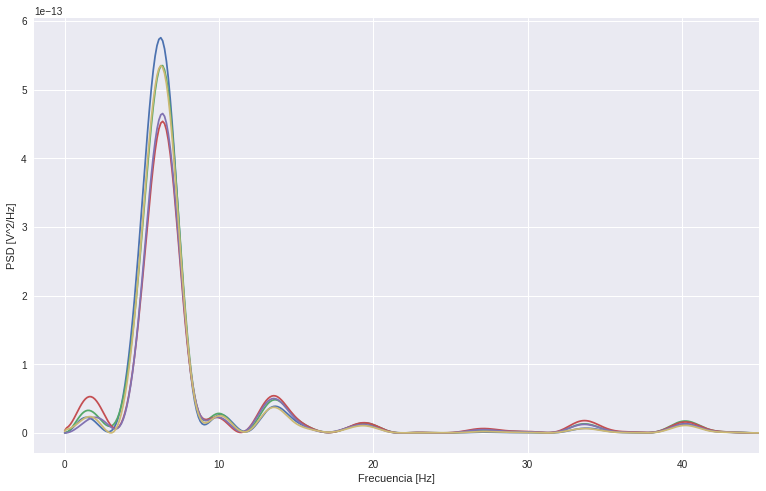

In [5]:
def mean_between_epochs(panel):
    return panel.mean(0)

mean_df = mean_between_epochs(panel).T

for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_electrode(mean_df[electrode])
plt.show()

plt.figure(figsize=(13, 8))
for electrode in ALPHA_RELEVANT_ELECTRODES:
    plot_welch(mean_df[electrode])
plt.show()


In [6]:
def mean_between_electrodes(panel, electrodes):
    return panel[:,electrodes].mean(1)

def fourier_per_epoch(panel, electrodes):
    samples_per_epoch = mean_between_electrodes(panel, electrodes)
    relevant_frecuencies = 38
    res = []
    for _, samples in samples_per_epoch.iteritems():
        frequencies, powers = signal.welch(samples, FREQ, nperseg=len(samples))
        res.append(powers[:relevant_frecuencies])
    return np.asarray(res), frequencies[:relevant_frecuencies]

spectrogram_alpha, frequencies_alpha = fourier_per_epoch(panel, ALPHA_RELEVANT_ELECTRODES)
#spectrogram_all, frequencies_all = fourier_per_epoch(panel, range(256))

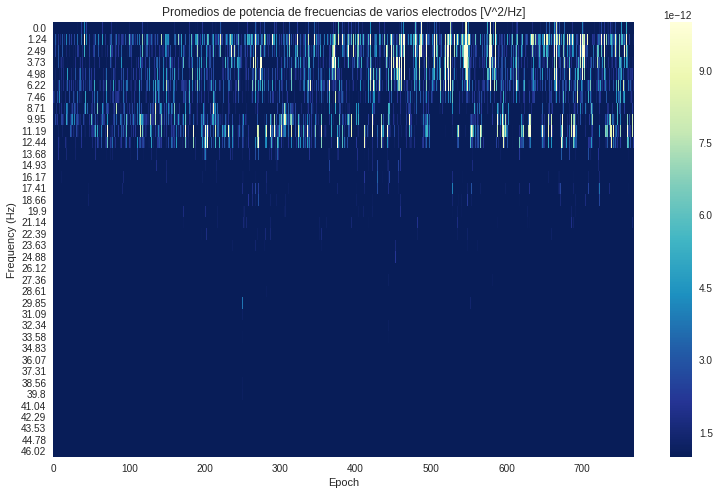

In [7]:
def plot_spectrogram(spectrogram, frequencies):
    spectrogram = spectrogram.T
    plt.figure(figsize=(13, 8))
    ax = sns.heatmap(spectrogram, 
                     xticklabels=100, yticklabels=frequencies.round(2), 
                     #cbar_kws=('PSD [V**2/Hz]'),
                     vmin=0.1e-11, vmax=1e-11, 
                     #center=1.5e-11,
                     cmap='YlGnBu_r'
                     )
    plt.title('Promedios de potencia de frecuencias de varios electrodos [V^2/Hz]')
    plt.xlabel('Epoch')
    plt.ylabel('Frequency (Hz)')
    plt.show()

plot_spectrogram(spectrogram_alpha, frequencies_alpha)

# Categorizamos las frecuencias según su tipo

In [8]:
def mean_power_per_frequency_range(panel):
    mean_samples = panel.mean(0).mean(0)

    def belongs(frequency_range, frequency):
        return frequency_range[0] <= frequency < frequency_range[1]

    frequencies, power = signal.welch(mean_samples, fs=FREQ, nperseg=len(mean_samples), nfft=2048)
    #plt.plot(frequencies, power)
    #plt.show()
    limits = {'delta': (0,4), 'tita': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma': (30, 45)}
    values_by_range = {'delta':[], 'tita':[], 'alpha':[], 'beta':[], 'gamma':[]}

    for f, p in zip(frequencies, power):
        for key, limit in limits.items():
            if belongs(limit, f):
                values_by_range[key].append(p)

    return {key: np.mean(value) for key, value in values_by_range.items()}

In [9]:
import gc
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]

powers_per_frequency_range_S = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    df[filename, 'S'] = mean
    #mean['type'] = 'S'
    powers_per_frequency_range_S.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,S01.mat,S02.mat,S03.mat,S04.mat,S05.mat,S06.mat,S07.mat,S08.mat,S09.mat,S10.mat
,S,S,S,S,S,S,S,S,S,S
alpha,1.026483e-18,1.499357e-18,3.320238e-18,3.497416e-18,4.276362e-19,2.216958e-18,3.623286e-18,2.314293e-17,2.360640e-15,1.292415e-18
beta,1.172613e-19,6.172815e-19,1.712920e-19,9.190571e-19,6.060159e-20,5.933165e-19,1.409402e-18,1.868437e-17,7.877802e-16,1.523475e-18
delta,1.758268e-17,4.472179e-18,4.065730e-18,9.692476e-17,2.184766e-18,2.676871e-18,9.826251e-16,2.543778e-16,9.245473e-15,2.870952e-17
gamma,4.288523e-20,6.504662e-20,2.128237e-20,4.400582e-19,5.554357e-21,1.775360e-19,4.502721e-19,3.741804e-18,1.776625e-16,7.228576e-19
tita,3.817061e-18,2.468836e-18,9.971159e-18,9.656797e-18,5.998928e-18,6.882406e-18,7.440617e-18,1.823955e-16,7.231300e-16,1.137504e-17


In [10]:
onlyfiles = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
powers_per_frequency_range_P = []
df = {}
for filename in onlyfiles:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    mean = mean_power_per_frequency_range(panel)
    #print(mean)
    df[filename,'P'] = mean
    #mean['type'] = 'P'
    powers_per_frequency_range_P.append(mean)
    del mat
    del panel
    gc.collect()
pd.DataFrame(df)

,P01.mat,P02.mat,P03.mat,P04.mat,P05.mat,P06.mat,P07.mat,P08.mat,P09.mat,P10.mat
,P,P,P,P,P,P,P,P,P,P
alpha,8.322370e-18,7.693092e-19,3.957020e-18,1.933729e-19,4.713734e-17,5.298699e-20,8.969275e-18,4.258323e-18,2.960869e-16,3.529571e-20
beta,1.381249e-18,5.162154e-19,7.868565e-19,2.817521e-20,1.474087e-17,1.924552e-20,3.656707e-18,9.709071e-19,5.746252e-16,1.003134e-20
delta,1.806363e-17,4.436316e-17,8.455879e-17,6.439284e-18,6.469527e-17,2.280204e-18,4.974773e-17,2.994808e-16,8.838420e-15,3.228125e-18
gamma,6.944751e-19,2.437774e-19,3.100376e-19,6.419603e-21,5.717399e-18,5.530914e-21,2.382617e-19,1.515331e-19,6.284587e-16,6.005801e-21
tita,7.487305e-17,2.017718e-17,6.628106e-18,3.055195e-18,3.237683e-16,4.937792e-19,8.327348e-17,1.215654e-16,2.475783e-15,2.994987e-19


(20, 5)
          alpha          beta         delta         gamma          tita
0  1.499357e-18  6.172815e-19  4.472179e-18  6.504662e-20  2.468836e-18
1  1.026483e-18  1.172613e-19  1.758268e-17  4.288523e-20  3.817061e-18
2  2.360640e-15  7.877802e-16  9.245473e-15  1.776625e-16  7.231300e-16
3  1.292415e-18  1.523475e-18  2.870952e-17  7.228576e-19  1.137504e-17
4  3.623286e-18  1.409402e-18  9.826251e-16  4.502721e-19  7.440617e-18
5  2.314293e-17  1.868437e-17  2.543778e-16  3.741804e-18  1.823955e-16
6  3.320238e-18  1.712920e-19  4.065730e-18  2.128237e-20  9.971159e-18
7  4.276362e-19  6.060159e-20  2.184766e-18  5.554357e-21  5.998928e-18
8  2.216958e-18  5.933165e-19  2.676871e-18  1.775360e-19  6.882406e-18
9  3.497416e-18  9.190571e-19  9.692476e-17  4.400582e-19  9.656797e-18
0  1.933729e-19  2.817521e-20  6.439284e-18  6.419603e-21  3.055195e-18
1  4.258323e-18  9.709071e-19  2.994808e-16  1.515331e-19  1.215654e-16
2  3.957020e-18  7.868565e-19  8.455879e-17  3.100376e-1

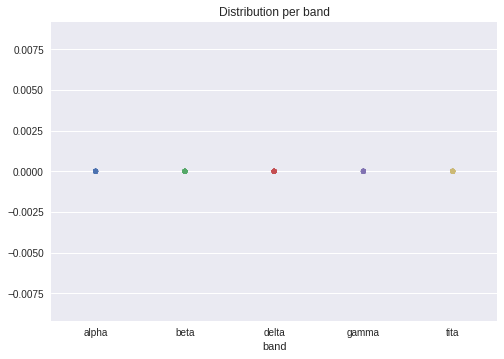

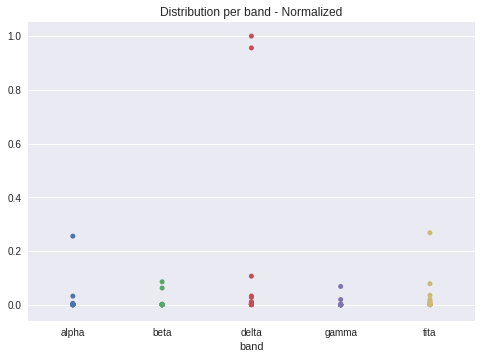

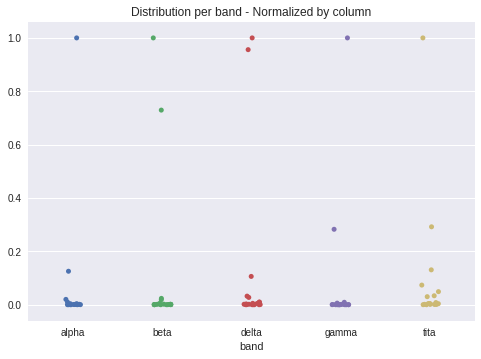

In [11]:
dS = pd.DataFrame(powers_per_frequency_range_S)
dP = pd.DataFrame(powers_per_frequency_range_P)
data = pd.concat([dS,dP])
print(data.shape)
print(data)

data = data.rename_axis("patient", axis=0)
data = data.rename_axis("band", axis=1)


ax = sns.stripplot(data=data, 
                   vmin=data.min().min(), 
                   vmax=data.max().max()
                  )
#ax.set_yscale('log')
plt.title('Distribution per band')
plt.show()

df = data
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.stripplot(data=df_norm, 
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()


df = data
df_norm = ( (df - df.min() ) / (df.max() - df.min()) )
ax = sns.stripplot(data=df_norm,
                   jitter=True,
                   vmin=df_norm.min().min(), 
                   vmax=df_norm.max().max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized by column')
plt.show()

# TODO: separar S y P en subcolumnas

## Realizamos todos los gráficos categóricos.
#### En ROJO los S, en AZUL los P.
Versión normalizados.

### Stripplot

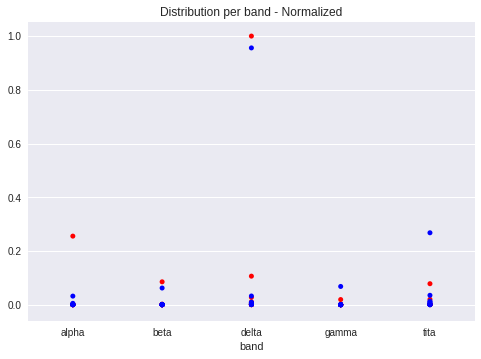

In [12]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.stripplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.stripplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Violin Plot

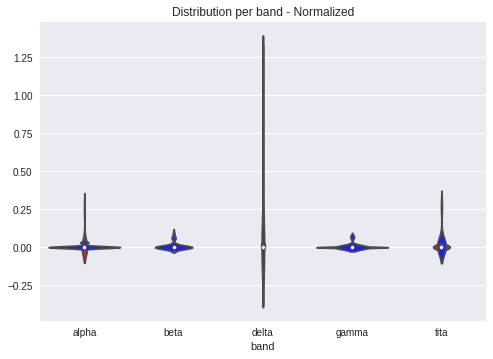

In [13]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.violinplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.violinplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Bar Plot

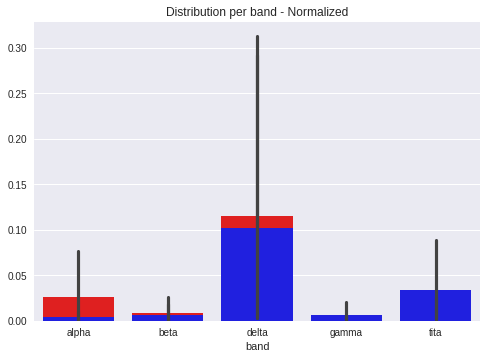

In [14]:
df_norm = (df - df.min().min()) / (df.max().max() - df.min().min())
ax = sns.barplot(data=df_norm[:10],
                   color="r"
                  )
ax = sns.barplot(data=df_norm[10:],
                   color="b"
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### SwarmPlot

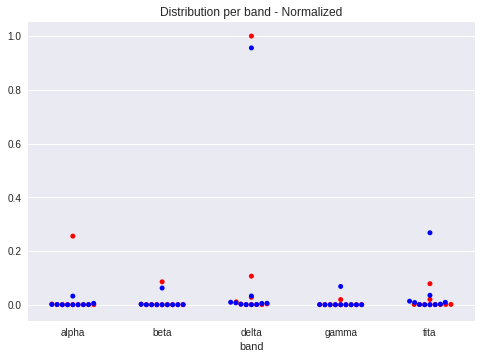

In [15]:
ax = sns.swarmplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.swarmplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### BoxPlot

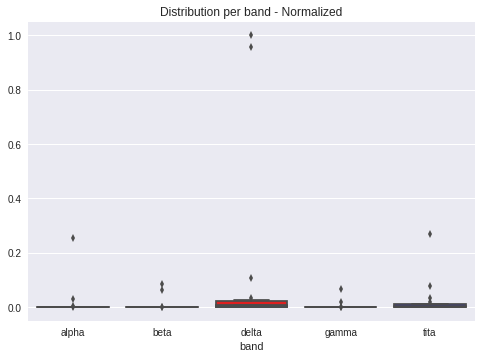

In [16]:
ax = sns.boxplot(data=df_norm[:10],
                   color="r",
                  )
ax = sns.boxplot(data=df_norm[10:],
                   color="b",
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

### Point Plot

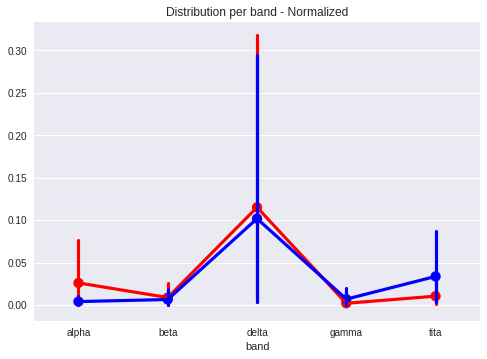

In [17]:
ax = sns.pointplot(data=df_norm[:10],
                   color="r",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
ax = sns.pointplot(data=df_norm[10:],
                   color="b",
                   vmin=df_norm.min(), 
                   vmax=df_norm.max() 
                  )
#ax.set_yscale('log')
plt.title('Distribution per band - Normalized')
plt.show()

## Gráficos categóricos

Elegimos usar de ahora en adelante el violin plot, ya que da un buen resúmen de la distribución de nuestros datos para cada categoría. 

## Análisis de información (intra-electrodo)

In [18]:
from scipy.io import loadmat
import pandas as pd

import gc
gc.collect()

mat = loadmat('data/S06.mat')
panel = pd.Panel(mat['data'])
''' Item axis: Epoch
    Major axis: Electrode
    Minor axis: Sample '''
min_ = panel.min().min().min()
max_ = panel.max().max().max()
bins = np.linspace(min_, max_, 100)

print(bins)

[ -4.81029570e-04  -4.73354745e-04  -4.65679920e-04  -4.58005094e-04
  -4.50330269e-04  -4.42655444e-04  -4.34980619e-04  -4.27305793e-04
  -4.19630968e-04  -4.11956143e-04  -4.04281317e-04  -3.96606492e-04
  -3.88931667e-04  -3.81256841e-04  -3.73582016e-04  -3.65907191e-04
  -3.58232365e-04  -3.50557540e-04  -3.42882715e-04  -3.35207889e-04
  -3.27533064e-04  -3.19858239e-04  -3.12183413e-04  -3.04508588e-04
  -2.96833763e-04  -2.89158937e-04  -2.81484112e-04  -2.73809287e-04
  -2.66134462e-04  -2.58459636e-04  -2.50784811e-04  -2.43109986e-04
  -2.35435160e-04  -2.27760335e-04  -2.20085510e-04  -2.12410684e-04
  -2.04735859e-04  -1.97061034e-04  -1.89386208e-04  -1.81711383e-04
  -1.74036558e-04  -1.66361732e-04  -1.58686907e-04  -1.51012082e-04
  -1.43337256e-04  -1.35662431e-04  -1.27987606e-04  -1.20312780e-04
  -1.12637955e-04  -1.04963130e-04  -9.72883045e-05  -8.96134792e-05
  -8.19386538e-05  -7.42638285e-05  -6.65890032e-05  -5.89141779e-05
  -5.12393526e-05  -4.35645272e-05

In [19]:
# a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

import scipy.stats
from collections import defaultdict
import numpy as np

import gc
gc.collect()

def compute_entropy(series):
    histogram, _ = np.histogram(series, bins)
    probabilities = [frecuency/len(series) for frecuency in histogram]
    return scipy.stats.entropy(probabilities)

def compute_entropies_for_subject(panel):
    n_epochs, n_electrodes, n_measures = panel.shape
    entropies = defaultdict(dict)
    for epoch in range(n_epochs):
        for electrode in range(n_electrodes):
            electrode_data = panel[epoch, electrode]
            entropy = compute_entropy(electrode_data)
            entropies[epoch][electrode] = entropy
    return pd.DataFrame(entropies)

(769,)


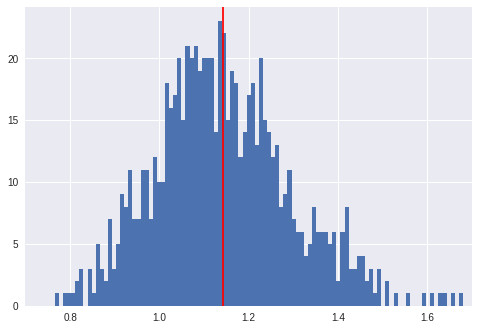

(256,)


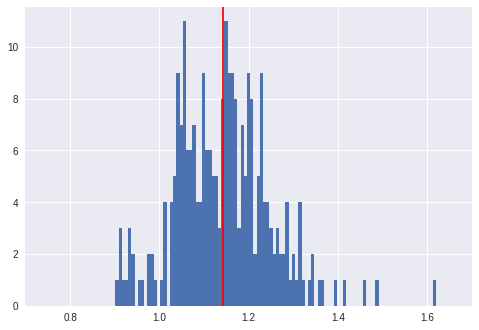

In [20]:
import matplotlib.pyplot as plt

def mean_between_epochs(df):
    return df.mean(0)
def mean_between_electrodes(df):
    return df.mean(1)

def plot_histograms_for_subject(entropies):
    # Promediamos por electrodos, obtenemos histograma por epochs
    mean_epochs = mean_between_epochs(entropies)
    print(mean_epochs.shape)
    mean_epochs.hist(bins=100)
    plt.axvline(mean_epochs.mean(), color='r')
    plt.xlim(0.7,1.7)
    plt.show()
    
    # Promediamos por epochs, obtenemos histograma por electrodos
    mean_electrodes = mean_between_electrodes(entropies)
    print(mean_electrodes.shape)
    mean_electrodes.hist(bins=100)
    plt.axvline(mean_electrodes.mean(), color='r')
    plt.xlim(0.7,1.7)
    plt.show()

def subject_global_mean(entropies):
    return entropies.mean().mean()

entropies = compute_entropies_for_subject(panel)
plot_histograms_for_subject(entropies)

In [21]:
from os import listdir
from os.path import join

files_S = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]
files_P = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
global_means_for_S = []
global_means_for_P = []

for filename in files_S:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = compute_entropies_for_subject(panel)
    global_mean = subject_global_mean(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_S.append(global_mean)
    del mat
    del panel
    gc.collect()
    
for filename in files_P:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = compute_entropies_for_subject(panel)
    global_mean = subject_global_mean(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_P.append(global_mean)
    del mat
    del panel
    gc.collect()

Subject: S02.mat, Entropy: 1.2799294989525245
Subject: S01.mat, Entropy: 1.0148988393166327
Subject: S09.mat, Entropy: 1.3230451458799564
Subject: S10.mat, Entropy: 1.0854490895815632
Subject: S07.mat, Entropy: 1.1437865203234128
Subject: S08.mat, Entropy: 1.2817693746290326
Subject: S03.mat, Entropy: 1.1537885098638416
Subject: S05.mat, Entropy: 1.232442421386174
Subject: S06.mat, Entropy: 1.1429101161815556
Subject: S04.mat, Entropy: 1.3231862707283253
Subject: P04.mat, Entropy: 1.227322176028006
Subject: P08.mat, Entropy: 0.9281087479479283
Subject: P03.mat, Entropy: 1.432141231390902
Subject: P05.mat, Entropy: 1.5453020832103916
Subject: P09.mat, Entropy: 1.5479685536047931
Subject: P01.mat, Entropy: 1.1765334579427171
Subject: P07.mat, Entropy: 1.4306758607778676
Subject: P02.mat, Entropy: 1.434636032407587
Subject: P10.mat, Entropy: 1.1768449509726735
Subject: P06.mat, Entropy: 1.2705160726633056


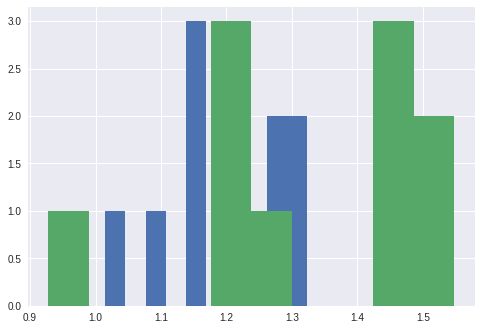

In [22]:
plt.hist(global_means_for_S)
plt.hist(global_means_for_P)
plt.show()

## Análisis de información (inter-electrodo)

In [24]:
import itertools
from functools import reduce

# TODO: revisar el bins global

def joint_entropy(signal_1, signal_2):
    _, bins_1 = np.histogram(signal_1, bins)
    _, bins_2 = np.histogram(signal_2, bins)
    
    signal_1 = np.digitize(signal_1, bins_1)
    signal_2 = np.digitize(signal_2, bins_2)
    
    signal = list(zip(signal_1, signal_2))
    probabilities = [signal.count(s) / len(signal) for s in signal]
    return scipy.stats.entropy(probabilities)
    

def inter_electrode_analysis(panel, epoch, electrode_1, electrode_2):
    signal_1 = panel[epoch, electrode_1]
    signal_2 = panel[epoch, electrode_2]
    return joint_entropy(signal_1, signal_2)

mat = loadmat(join('data', 'S01.mat'))
panel = pd.Panel(mat['data'])
inter_electrode_analysis(panel, 0, 8, 24)

5.192223006127854

             0
0     5.079917
1     5.102379
2     5.064833
3     5.089477
4     5.130965
5     5.066657
6     5.065303
7     5.151258
8     5.080531
9     5.076731
10    5.063829
11    5.086623
12    5.047452
13    5.051162
14    5.107115
15    5.058838
16    5.058011
17    5.092544
18    5.112136
19    5.077454
20    5.222403
21    5.228345
22    5.240451
23    5.225740
24    5.215098
25    5.167112
26    5.174407
27    5.150740
28    5.142734
29    5.160095
...        ...
8910  5.153825
8911  5.107965
8912  5.161205
8913  5.152163
8914  5.149383
8915  5.194589
8916  5.162047
8917  5.209770
8918  5.130922
8919  5.161109
8920  5.203521
8921  5.077970
8922  5.089415
8923  5.168242
8924  5.229011
8925  5.232453
8926  5.180988
8927  5.076195
8928  5.137556
8929  5.166867
8930  5.186938
8931  5.219746
8932  5.221158
8933  5.178842
8934  5.181720
8935  5.178680
8936  5.163387
8937  5.099638
8938  5.138936
8939  5.081703

[8940 rows x 1 columns]
(1,)


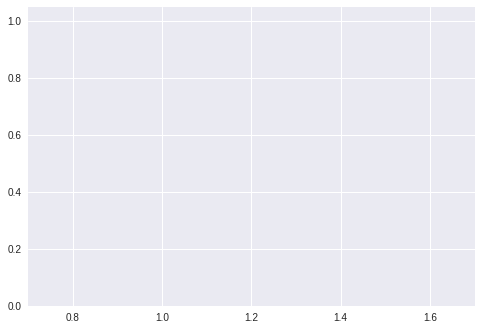

(8940,)


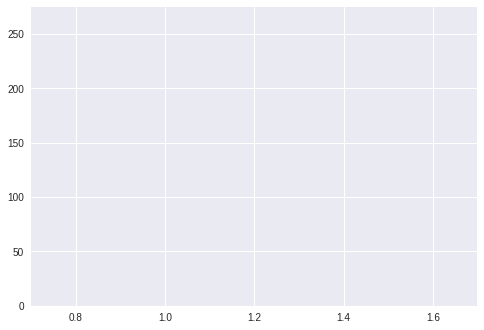

0    5.135341
dtype: float64

In [25]:
from itertools import combinations
ALPHA_RELEVANT_ELECTRODES = [8,44,80,131,185]

def joint_entropy_for_subject(panel):
    entropies = []
    n_epochs, n_electrodes, n_measures = panel.shape
    for epoch in range(n_epochs):
        for combination in combinations(ALPHA_RELEVANT_ELECTRODES, 2):
            entropies.append(inter_electrode_analysis(panel, epoch, *combination))
    return pd.DataFrame(entropies)

def plot_histogram_for_joint_entropies(entropies):
    entropies.hist()
    plt.show()
    
def mean_of_entropies(entropies):
    return entropies.mean()

panel = pd.Panel(loadmat('data/P01.mat')['data'])
entropies = joint_entropy_for_subject(panel)
print(entropies)
plot_histograms_for_subject(entropies)
mean_of_entropies(entropies)

In [26]:
from os import listdir
from os.path import join

files_S = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('S'))]
files_P = [f for f in listdir('data') if (f.endswith('.mat') and f.startswith('P'))]
global_means_for_S = []
global_means_for_P = []

for filename in files_S:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = joint_entropy_for_subject(panel)
    global_mean = mean_of_entropies(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_S.append(global_mean)
    del mat
    del panel
    gc.collect()
    
for filename in files_P:
    mat = loadmat(join('data', filename))
    panel = pd.Panel(mat['data'])
    entropies = joint_entropy_for_subject(panel)
    global_mean = mean_of_entropies(entropies)
    print("Subject: {}, Entropy: {}".format(filename, global_mean))
    global_means_for_P.append(global_mean)
    del mat
    del panel
    gc.collect()

Subject: S02.mat, Entropy: 0    5.117976
dtype: float64
Subject: S01.mat, Entropy: 0    5.117011
dtype: float64
Subject: S09.mat, Entropy: 0    5.124949
dtype: float64
Subject: S10.mat, Entropy: 0    5.121202
dtype: float64


KeyboardInterrupt: 